<a href="https://colab.research.google.com/github/nalgo-intern/team-a-2025-summer-08-04/blob/ryotaro_branch/one_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pathlib

import numpy as np
import pandas as pd


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow as tf
from tf.keras.datasets import mnist
#from datasets import mnist
#from tensorflow.keras.datasets import mnist
import numpy as np
from scipy.ndimage import zoom

def make_double_images(images, labels, num_samples):
    double_images = []
    double_labels = []

    for _ in range(num_samples):
        idx1 = np.random.randint(0, len(images))
        idx2 = np.random.randint(0, len(images))

        img1 = images[idx1]
        img2 = images[idx2]

        combined = np.concatenate([img1, img2], axis=1)  # 横に結合（28x56）
        resized = zoom(combined, (1.0, 0.5))              # 横を0.5倍にして28x28に
        resized = resized / 255.0                         # 正規化

        double_images.append(resized)
        double_labels.append(labels[idx1]*10 + labels[idx2]) #ラベルを二桁に
####
#二桁を分割して28*14にする場合は、のちのモデルを書き換え、学習済みモデルを作る必要がある。
####
    return np.array(double_images), np.array(double_labels)

def load_double_data(num_train_samples=90000, num_test_samples=10000):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train, y_train = make_double_images(x_train, y_train, num_train_samples)
    x_test, y_test = make_double_images(x_test, y_test, num_test_samples)

    return (x_train, y_train), (x_test, y_test)

In [5]:
print("numpy :", np.__version__)
print("pandas :", pd.__version__)
print("tensorflow :", tf.__version__)
print("matplotlib :", matplotlib.__version__)

numpy : 2.0.2
pandas : 2.3.1
tensorflow : 2.18.1
matplotlib : 3.10.0


In [6]:
#ここはColab用に学習の遷移のためのファイル。
CSV_FILE_PATH = "trainlog.csv"
if not os.path.exists(CSV_FILE_PATH):
    pathlib.Path(CSV_FILE_PATH).touch()

In [8]:
#データロード
(X_train, y_train),(X_test, y_test) = load_double_data()

In [9]:
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_train :  (90000, 28, 28)
y_train :  (90000,)
X_test :  (10000, 28, 28)
y_test :  (10000,)


y_train (i=1):  75
X_train (i=1): 


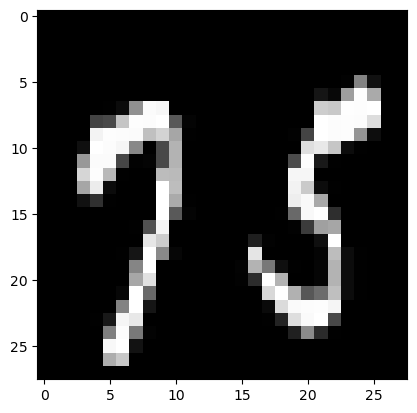

y_train (i=10):  41
X_train (i=10): 


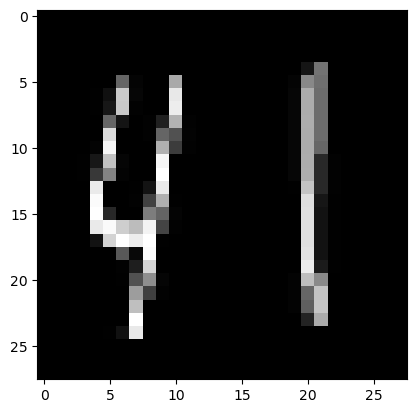

y_train (i=100):  66
X_train (i=100): 


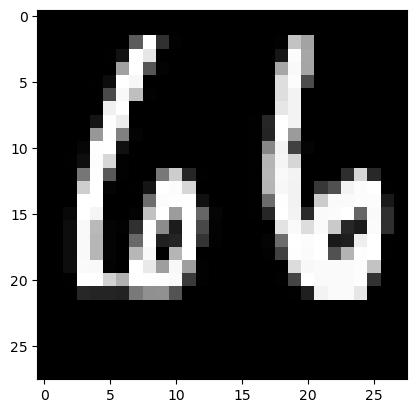

In [10]:
#画像データの確認
for i in [1,10,100]:
   print("y_train", "(i="+str(i)+"): ", y_train[i])
   print("X_train", "(i="+str(i)+"): ")
   plt.imshow(X_train[i], cmap='gray')
   plt.show()

In [11]:
#入力値の確認
print("X_train min", X_train.min())
print("X_train max", X_train.max())

X_train min 0.0
X_train max 1.0


In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28), name='input'),
    #二桁を分割して、28*14を入力するときは、input_shapeを書き換え

    tf.keras.layers.Dense(512, name='dense_1'),
    tf.keras.layers.Activation(tf.nn.relu, name='gelu_1'),

    tf.keras.layers.Dense(256, name='dense_2'),
    tf.keras.layers.Activation(tf.nn.relu, name='gelu_2'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(256, name='dense_3'),
    tf.keras.layers.Activation(tf.nn.relu, name='gelu_3'),
    tf.keras.layers.Dense(100, name='dense_4'),
    #今回の出力は0~99のどれか一つを出力するので、100としている。
    tf.keras.layers.Activation(tf.nn.softmax, name='softmax')
])

c:\Users\sen0v\Music\folder\envs\AI_ML\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (Flatten)                 │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gelu_1 (Activation)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gelu_2 (Activation)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gelu_3 (Activation)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 100)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 624,740 (2.38 MB)

 Trainable params: 624,740 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# コンパイルの方式
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
callbacks = []
callbacks.append(tf.keras.callbacks.CSVLogger(CSV_FILE_PATH))

In [16]:
#学習
history = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=30,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

Epoch 1/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5515 - loss: 1.7350 - val_accuracy: 0.8695 - val_loss: 0.4368
Epoch 2/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8877 - loss: 0.3795 - val_accuracy: 0.9089 - val_loss: 0.3001
Epoch 3/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9276 - loss: 0.2308 - val_accuracy: 0.9207 - val_loss: 0.2714
Epoch 4/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9514 - loss: 0.1544 - val_accuracy: 0.9323 - val_loss: 0.2496
Epoch 5/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9634 - loss: 0.1153 - val_accuracy: 0.9324 - val_loss: 0.2546
Epoch 6/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9693 - loss: 0.0941 - val_accuracy: 0.9314 - val_loss: 0.2664
Epoch 7/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9740 - loss: 0.0789 - val_accuracy: 0.9347 - val_loss: 0.2821
Epoch 8/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9795 - loss: 0.0630 - val_accuracy: 0

In [17]:
# テスト
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=1)
print("loss(train): {:.4}".format(train_loss))
print("accuracy(train): {:.4}".format(train_acc))

print()

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("loss(test): {:.4}".format(test_loss))
print("accuracy(test): {:.4}".format(test_acc))

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9962 - loss: 0.0114
loss(train): 0.0111
accuracy(train): 0.9963

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9424 - loss: 0.3633
loss(test): 0.3694
accuracy(test): 0.9427


In [18]:
df = pd.read_csv(CSV_FILE_PATH)
df.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.725756,0.980560,0.8695,0.436849
1,1,0.896811,0.349219,0.9089,0.300148
2,2,0.930111,0.224547,0.9207,0.271382
3,3,0.951189,0.156355,0.9323,0.249617
4,4,0.962389,0.120796,0.9324,0.254592


In [19]:
epochs = df["epoch"].values
train_acc = df["accuracy"].values
train_loss = df["loss"].values
test_acc = df["val_accuracy"].values
test_loss = df["val_loss"].values

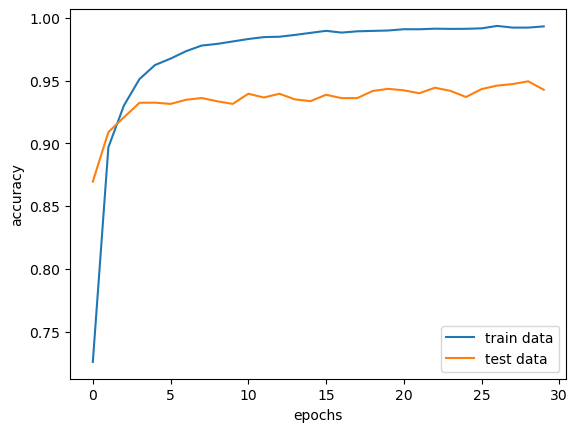

In [20]:
plt.plot(epochs, train_acc, label="train data")
plt.plot(epochs, test_acc, label="test data")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="lower right")
plt.show()

In [21]:
# テスト結果の表
import matplotlib.pyplot as plt
import numpy as np

ROW = 6
COLUMN = 8
num_images = ROW * COLUMN
predictions = model.predict(X_test[:num_images])

y_preds = np.argmax(predictions, axis=1)


fig = plt.figure(figsize=(12, 8))


for i in range(ROW * COLUMN):
    y_true = y_test[i]
    y_pred = y_preds[i]

    if y_true == y_pred:
        result = "True"  # 正解
    else:
        result = "False" # 不正解

    plt.subplot(ROW, COLUMN, i+1)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f"No.{i} - {result}\ny_true:{y_true}, y_pred:{y_pred}")
    plt.axis("off")

fig.tight_layout()
fig.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


C:\Users\sen0v\AppData\Local\Temp\ipykernel_25444\3144287143.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [22]:
#出力のonehotをヒストグラムで描画
# まばらになっているほど精度が悪い結果を出している。
prediction_probabilities = predictions[8]

class_labels = np.arange(len(prediction_probabilities))

# 棒グラフ
plt.figure(figsize=(10, 6))
bars = plt.bar(class_labels, prediction_probabilities, color='skyblue', label='Probability')

plt.xlabel('Class Label')
plt.ylabel('Probability')
plt.xticks(class_labels)  # X軸の目盛りをクラスラベルに設定
plt.ylim(0, 1)            # Y軸の範囲を0から1に設定
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 最も確率の高い棒をハイライトする
predicted_class = np.argmax(prediction_probabilities)
bars[predicted_class].set_color('royalblue')

plt.legend()
plt.tight_layout()


In [23]:
#ジニ係数をだすパート
# 一桁の推定->二桁の推定の移行を行う場合に役立つ
# そのまま、数字を推定する場合はいらない。
import numpy as np

squared_probs = np.square(predictions)
sum_squared_probs = np.sum(squared_probs, axis=1)
gini_coefficients = 1 - sum_squared_probs

gini_list = []
# 結果の表示
for i, gini in enumerate(gini_coefficients):
    #print(f"Prediction {i+1} {predictions[i]}: Gini = {gini:.4f}")
    gini_list.append(gini)

plt.plot(gini_list)

In [24]:
# 学習済みモデルの保存
ins_path = 'trained_model_v0.h5'
model.save(ins_path)